

# 실습 8 오토인코더




본 실습에서 사용하는 데이터셋의 출처는 다음과 같음을 밝힌다.

raw data: Fisher, R.A. (1936). "The Use of Multiple Measurements in Taxonomic Problems", Annals of Eugenics . 7  (2): 179–188



### 0. 인트로

오토인코더 모델을 생성하고 이를 학습시키기 위해 다음의 것들을 먼저 불러온다. 아래에서 불러온 것들을 보면 이번 실습에서 밀집층(Fully Connected Layer, Dense Layer : 입력과 출력을 모두 연결해주는 층)을 사용하고 손실함수로 평균제곱오차를, 옵티마이저로 Adam을 이용하는 것을 어느 정도 짐작할 수 있다.


In [ ]:
import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

이 실습에서는 선형 오토인코더 모델을 정의하는 연습을 할 것이다. 개념 파트에서 잠깐 언급했듯이 오토인코더의 내부 구조는 인코더와 디코더로 이루어져 있다. 인코더에 데이터를 보내면 보다 중요하고 집약적인 특징을 출력하고 이를 다시 디코더로 보내 원래의 데이터를 복구하고자 하는 것이 오토인코더였다. 이를 기억하면서 오토인코더 모델을 만들고 iris 데이터셋으로 모델을 학습시켜 모델이 잘 정의되었는지 확인하면 된다. 이 iris 데이터셋은 4차원 행백터가 총 150개 존재하는, 3종의 꽃 'satosa', 'versicolor', 'virginica'에 대한 데이터셋이다.

이 꽃들이 가진 특징에 따라 iris 데이터셋 안의 데이터들은 여러 클러스터링을 이루며 존재한다.(이미 임베딩 되어 있는 데이터이기 때문이다.) 이 데이터셋으로 오토인코더를 학습시킬 것이며, 이때 손실함수로는 평균 제곱 오차를 사용하여 모델의 정확도를 높여나갈 것이다. 또한, 경사하강법으로 인코더의 정확도가 올라갈 수 있도록 하는 적절한 모델 파라미터를 찾을 것이다.
이런 오토인코더가 필요한 이유는 무엇일까? 바로 데이터가 갖는 노이즈를 최대한 없애는 데에 있다. 이 오토인코더를 통해 신경망을 학습하는 과정에서, 인코더와 디코더를 거치기 때문에 두 개의 밀집층(dense layer)가 필요하며 ‘선형’ 오토인코더를 제작하는 것이어서 활성화 함수 없이 신경망을 학습시켜야 한다.

In [ ]:
import torch.nn as nn

class LinearAutoencoder(nn.Module):
    def __init__(self, D_full, D_hidden):
        """ 모델의 모든 층(layer)을 초기화하는 함수.

        매개변수(Parameters)
        ----------
        D_full : int
            처음 입력값의 크기(e.g. 4차원 데이터가 입력값이라면 D_full = 4).

        D_hidden : int
            인코더를 지난 데이터가 도달하는 은닉층의 크기 (i.e., 축소된 차원).
        """
        # weight initializer로 `He Normal` 초기화인 kaiming_normal_()을 사용해서 인코더와 디코더가 갖는 밀집층을 초기화하자.

        # 입력과 출력값이 가지는 층의 차원은 어떠할지 생각해보면서 인코더와 디코더가 갖는 밀집층을 생성하라.
        # 여기에 코드 작성
        super().__init__()

        self.linear1 = nn.Linear(D_full, D_hidden, bias = False)
        self.linear2 = nn.Linear(D_hidden, D_full, bias = False)

        # `He Normal`을 사용하여 가중치 초기화
        nn.init.kaiming_normal_(self.linear1.weight)
        nn.init.kaiming_normal_(self.linear2.weight)

    def forward(self, x):
        """순전파를 수행하여 데이터를 모델 입력으로 보내기.

        이는 모델 ‘m’을 간편하게 초기화할 수 있도록 해주고 ‘m(x)’을 불러와서 분류하고자 하는 데이터를 보낸다.

        매개변수(Parameters)
        ----------
        x : Union[numpy.ndarray, torch.Tensor], shape=(M, D_full)
            각 데이터가 D_full 차원을 가지면서 M 조각으로 이루어진 데이터 묶음.

        반환 값(Returns)
        -------
        torch.Tensor, shape=(M, D_full)
           M 조각의 데이터에 대해 모델이 예측한 값.
        '''
        # 지금 생성하는 모델이 선형 모델임을 유의하라. - “활성화 함수”가 존재하지 않는다.

        """
        # 여기에 코드 작성
        return self.linear2(self.linear1(x))

In [ ]:
# 모델 인스턴스 생성
D_full = 4  # 예시로 사용한 입력 차원
D_hidden = 2  # 예시로 사용한 은닉층 차원
model = LinearAutoencoder(D_full, D_hidden)

print(model.linear1)
print(model.linear2)

Linear(in_features=4, out_features=2, bias=False)
Linear(in_features=2, out_features=4, bias=False)


### 2. 데이터를 오토인코더에 넣어 학습시키기

#### 1)　iris 데이터셋 불러오기
 우리는 iris라는 데이터셋을 이용하여 오토인코더를 학습시킬 것이다. 앞에서 얘기했듯이 이 iris에 포함된 데이터는 이미 임베딩이 되어 있는 상태이다. 따라서 비슷한 종끼리 임베딩이 된 차원(여기서는 4차원이다.)에서 클러스터를 형성할 것이다. 먼저 다음 코드로 iris 데이터셋을 불러오도록 하자.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
iris_numpy = np.load("/content/drive/MyDrive/Classroom/advanced/8/iris_data.npy") # 경로는 본인이 저장한 경로로 설정하기 바란다.
# 경로 예시 : content/drive/MyDrive/iris_data.npy
# 경로 내의 모든 ' \ '는 ' / ' 로 바꾸어야 함! (\ 로 사용 시 에러 발생)

# 아래 코드를 출력해보면 4차원의 행벡터가 출력된다.
# 그 벡터는 [sepal length, sepal width, petal length, petal width]로 표현되어 있다.

print(iris_numpy[1])
# 결과 : [4.9 3.  1.4 0.2]

# print(iris_numpy)를 하면 shape이 (150, 4)인 행렬을 얻을 수 있다.
print(iris_numpy.shape) # (150, 4) 나오는지 확인

[4.9 3.  1.4 0.2]
(150, 4)


#### 생각해보기
불러온 iris 데이터가 shape을 갖고 있는지 확인해보고 몇 차원에 임베딩이 되어 있는지도 알아보자. 이를 위해선 먼저 데이터를 표준화시켜줄 필요가 있다. 이를 고려해 iris 데이터셋을 정규화하는 코드를 작성해보고 마지막으로 iris 데이터의 shape까지 확인해보자. 정규화할 때 평균과 표준편차가 이용되었다는 사실을 기억하면서 해보면 어렵지 않다.

In [22]:
def norm(x):
    """
    표준화한 데이터를 반환하는 함수

    매개변수 (Parameters)
    ----------
    x : array_like, shape-(N,)

    반환 값 (Returns)
    -------
    normed_x : array_like, shape-(N,)
    """
    return x / np.sqrt(np.sum(x**2))

In [23]:
iris_numpy = norm(iris_numpy)


iris_numpy.shape
# 정규화를 진행해도, 데이터의 shape는 바뀌어서는 안된다.
#(150, 4) 나오는지 확인

(150, 4)

#### 2) 선형 오토인코더 모델을 이용해 데이터셋을 학습하는 코드 작성하기
마지막으로 D_hidden=2(은닉층이 갖는 차원을 의미하며 데이터를 2차원에 정사영)로 설정하고 신경망을 평균 제곱 오차를 통해 학습시키는 것이 최종 목표이다. 현재 iris 내 데이터는 모두 4차원이므로 이를 2차원으로 축소하고 다시 4차원으로 복원하는 과정을 거칠 것이다. 이때 알아 두어야 할 것은 batch, epoch의 개념이다. 먼저 하나의 데이터를 통째로 학습하면 모델이 한번 학습하는 시간이 길어진다. 따라서 우리가 사용하는 iris 데이터셋 내의 데이터를 여러 소그룹으로 나누어야 효율적인 학습이 이루어질 수 있다. 이때 이 소그룹에 들어가는 데이터의 개수를 batch size라고 정의한다.


이때 epoch는 batch라는 소그룹으로 이루어진 데이터셋의 데이터들이 모두 신경망을 통과했을 때 epoch += 1이 될 수 있다. iteration은 모든 데이터가 신경망을 통과하기까지, 즉 1 epoch가 될 때까지 학습을 반복해야 하는 횟수를 의미한다. 만약 데이터셋에 들어간 데이터 수가 500이고 batch size가 25라면 iteration은 20이 될 것이다.


In [24]:
# numpy 배열을 tensor로 변환하고 iris에 저장한다.
iris = torch.Tensor(iris_numpy)

# ① 4차원을 2차원으로 축소하는 오토인코더란 선형 모델을 정의
# 앞에서 정의했던 'LinearAutoencoder' 모델을 이용하여 정의하면 된다.
# 여기에 코드 작성
model = LinearAutoencoder(D_full = 4, D_hidden = 2)

# ② batch size는 25로 하고 신경망을 학습시키는 횟수(epochs)는 500으로 충분하다.
# 이때 최적화 방법은 모델의 기본 파라미터를 불러오고 SGD optimizer을 사용하며 learning rate = 0.1로 한다. (손실이 너무 커서 예측값과 실제값의 차이가 많이 난다면, 학습률(learning rate)을 조정하여 학습의 정확도를 높혀볼 수 있다.)
# 여기에 코드 작성
batch_size = 25
num_epochs = 500
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# 그래프 그리기 위해 loss 저장
loss_values = []

# ③ 여기서부터는 표시되어있는 # 에 정답을 채워나가보자.
for epoch_cnt in range(num_epochs): # 위에서 정의한 변수 사용
    # 한 번의 epoch가 반복될 때마다 시행하는 코드

    # 학습용 데이터셋을 무작위로 재배열하기
    # `idxs`를 무작위로 재배열하여 데이터셋의 인덱스를 어떻게 재배열할지 결정
    idxs = np.arange(len(iris))
    np.random.shuffle(idxs) # -> array([0, 1, ..., 149])


    for batch_cnt in range(len(iris)//batch_size): # 여기에 코드 작성:
        batch_indices = idxs[batch_cnt * batch_size:(batch_cnt + 1) * batch_size]
        batch = iris[batch_indices]

        prediction = model(batch)
        truth = batch # 우리가 원하는 것은 모델이 최대한 원래 입력값에 가까운 값을 도출하도록 하는 것이므로 정답(truth value)을 정의해줄 필요가 있다.

        # loss는 MSE 사용
        # MSELoss(예측값, 정답) 형태로 사용
        loss = criterion(prediction, truth)

        # loss를 구했으면 이제 loss로 모델 최적화를 해주면 된다.
        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 역전파 진행
        loss.backward()

        # 미리 생성한 optimizer 객체를 이용하여, 모델 파라미터를 한 차례 갱신
        optimizer.step()

    # ④ 각 epoch 별 손실을 구하고 이를 그래프로 나타내는 코드
    # 총 500 epoch이므로 100회마다 손실을 그래프에 나타내보자.
    # 여기에 코드 작성
    if epoch_cnt%100 == 0:
        with torch.no_grad(): # 학습이 아니라 단순히 계산하는 것이므로
            prediction = model(iris) # 모델 전체에 대한 손실을 계산. batch에 대한 손실이 아님을 주의
            truth = iris
            loss = criterion(prediction, truth) # 위와 같은 방식으로 MSE 사용
        print(f'epoch {epoch_cnt:5}, loss = {loss.item():0.3f}')
        loss_values.append((epoch_cnt, loss.item())) # 리스트에 100 epoch마다 손실 저장

epoch     0, loss = 0.007
epoch   100, loss = 0.001
epoch   200, loss = 0.001
epoch   300, loss = 0.001
epoch   400, loss = 0.001


#### 3) 손실을 나타내기 위한 코드 작성
loss_values에는 100 에포크마다 손실 정도가 저장되어 있다.

matplotlib을 이용하여 리스트에 저장된 손실 정도를 그래프를 통해 볼 수 있다.

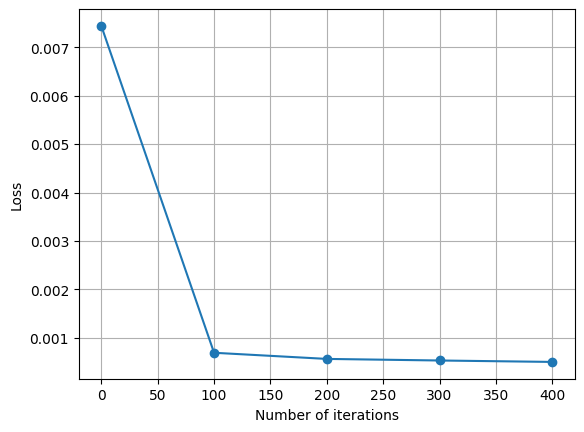

In [25]:
# Loss 그래프 plot
epochs, losses = zip(*loss_values) # loss_values = [(0, 0.5942912697792053), (100, 0.042074669152498245), ..
plt.plot(epochs, losses, marker='o')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

그래프를 확인해보면 100번의 epoch가 실행될 때마다 그 손실 값은 점점 작아져 특정 값으로 수렴할 것이다. 손실을 더 줄이고 싶다면 batch size나 epoch 수를 조정하면서 최적점을 찾도록 하자.
#### 생각해보기
1. 인코더만 적용해서 축소된 형태의 데이터(reduced라는 이름으로 저장하기)를 얻고 싶다면 데이터를 오토인코더에서 완전한 순전파를 하지 않고 앞에서 LinearAutoencoder 모델을 정의할 때 같이 정의했던 'linear1’만을 이용해서 전송하면 된다.


In [26]:
# 인코더만 적용한 형태로 reduced는 2차원 열벡터가 총 150개 존재하므로 ([150, 2]) tensor가 될 것이다.
# 이를 참고하여 reduced를 정의해보자.

with torch.no_grad():
# 여기에 코드 작성
  reduced = model.linear1(iris)
reduced.shape # (150, 2) 나오는지 확인

torch.Size([150, 2])

참고) 축소된, 인코딩 된 iris 데이터셋의 데이터는 은닉층이 2차원이므로 2차원의 평면에 정사영 어떤 직선이나 평면을 a라는 평면으로 정사영 하고 싶다면 a 평면에 나타난 그림자로 정사영 한다는 의미
 되었을 것이다.

### 3. 차원이 축소된 데이터를 시각화해보기

reduced라고 저장한, 즉 축소된 차원에서의 데이터를 시각화하는 작업을 거쳐보자. 서로 다른 세 종의 데이터를 다른 색깔로 표기해 그래프에 나타내면 각 층이 어떤 클러스터링을 이루고 있는지 볼 수 있다. 같은 종의 꽃들이 비슷한 위치 관계를 이루며 클러스터링을 이루고 있다면 성공적으로 오토인코더가 기존 데이터가 가진 특징을 살려 차원을 잘 축소했다는 것이다! 지금까지 모델 학습을 잘 거치고 reduced를 잘 정의했다면 아래와 같은 그래프가 나올 것이니 직접 확인해보도록 하자.

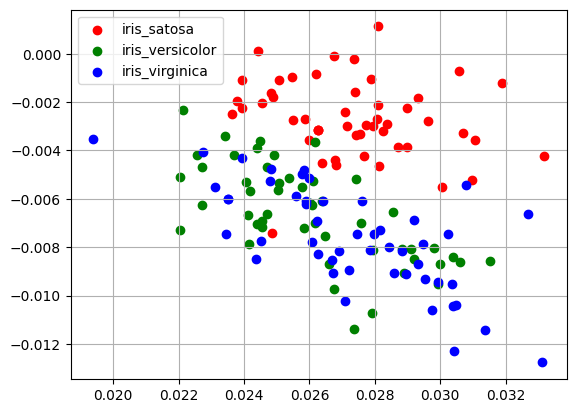

In [27]:
names = ['iris_satosa', 'iris_versicolor', 'iris_virginica']
colors = ['red', 'green', 'blue']

fig, ax = plt.subplots()
for i in range(3):
    x = reduced[i*50 : (i+1)*50, 0]
    y = reduced[i*50 : (i+1)*50, 1]
    ax.scatter(x, y, c = colors[i], label = names[i])
ax.grid()
ax.legend()

위 코드의 실행 후 출력된 그래프는 reduced에 대한 정보이므로 2차원 평면에 나타난 축소된 데이터다. 다시 말해 은닉층이 현재 2차원이고 원래의 iris 데이터는 4차원이므로 4차원의 데이터가 2차원 평면에 정사영 될 것이고 그 형태가 바로 위의 그래프인 것이다.

실습 6 오토인코더도 이렇게 마무리되었다. 잘 정의된 오토인코더의 인코더에 데이터를 통과시켰을 때 원래의 데이터(raw data)가 가진 특징을 잘 추출하면서 차원이 축소될수록 오토인코더의 학습이 잘 이루어진 것이다. 위 결과 그래프가 예상한 것보다 이상적인 클러스터링을 이루고 있지 않은 것 같다면, 앞서 모델 학습 과정에서 설정한 batch 등의 파라미터를 조정하면서 최적점을 찾아가는 것도 의미있을 것이다. 이번 실습에서 가장 중요한 것은 오토인코더 내의 인코더와 디코더가 각각 내놓는 출력물이 어떤 것인지 이해하고 이를 임베딩 개념과 잘 엮는 것이다.
지금까지 오토인코더의 역할을 공부했으니 마지막 실습 7에서는 앞에서 배운 임베딩 개념을 오토인코더와 함께 종합적으로 이해해보는 시간을 가질 것이다. 지금까지는 이미 임베딩 되어있는 파일을 사용했다면, 바로 이어질 실습에서는 아직 임베딩 되지 않은 텍스트 파일을 이용한다. 앞서 개념 파트에서 잠시 짚고 넘어갔던 의미론적 유사성을 기반으로 모델이 학습하는 방법 중 ‘문맥 행렬(context matrix)’ 개념을 도입하여 워드 임베딩을 학습시켜보는 시간을 가질 것이다.

### 배운 내용 되돌아보기

□ 인코더와 디코더가 갖는 밀집층을 정의하고 데이터셋을 보낼 수 있는 선형 오토인코더 모델을 작성하였다.

□ iris 데이터셋을 불러오고 이를 앞서 정의한 선형 오토인코더 모델이 학습하도록 하는 코드를 작성하였다. 이 과정에서 우리는 batch, epoch, iteration의 개념을 복습하였고, 이를 통해 모델이 학습하면서 손실을 줄여나갈 수 있는 방법을 고안하였다.

□ 오토인코더의 인코더만을 지난 차원이 축소된 데이터를 얻고, 이 데이터를 시각화해봄으로써 iris 데이터셋의 데이터가 오토인코더를 지나면서 그 차원이 제대로 축소되었는지 눈으로 확인해보았다.
